In [314]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [44]:
raw_data = pd.read_excel("CART Musc FIs sorted.xlsx", sheet_name=None, header=None)
raw_data.keys()

dict_keys(['CART BL', 'CART Post', 'Musc BL', 'Musc Post'])

In [747]:
df = raw_data["Musc BL"][:]
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,Date,2022-05-01 00:00:00,NaN,2022-05-01 00:00:00,NaN,2022-05-01 00:00:00,NaN,27.05.2019,NaN,28.05.2019,...,02.09.2019,NaN,02.09.2019,NaN,03.09.2019,NaN,03.09.2019,NaN,19.09.2019,NaN
1,Cell No,1,NaN,2,NaN,3,NaN,1,NaN,1,...,1,NaN,2,NaN,3,NaN,4,NaN,3,NaN
2,Rin,8.5,NaN,17.1,NaN,29.4,NaN,10.4,NaN,24.9,...,17.3,NaN,30.5,NaN,48.9,NaN,85.8,NaN,128.9,NaN
3,Rheo,809.22002,NaN,641.97002,NaN,293.23999,NaN,908.72998,NaN,463.17998,...,527.7,NaN,239.45,NaN,151.869995,NaN,90.369995,NaN,137.880005,NaN
4,Type,1,NaN,1,NaN,1,NaN,1,NaN,1,...,1,NaN,1,NaN,2,NaN,2,NaN,2,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,809.22002,NaN,641.97002,NaN,293.23999,NaN,908.72998,NaN,463.17998,...,527.7,NaN,239.45,NaN,151.869995,NaN,90.369995,NaN,137.880005,NaN
7,NaN,830.92998,4.608295,652.42002,9.560229,307.8,6.868132,915.359961,15.105741,484.17998,...,545.65,5.567929,259.369995,5.020080,176.269995,4.098361,108.490002,5.518764,148.490002,9.425071
8,NaN,843.359961,8.038586,661.58999,10.917030,318.480005,9.363296,931.090039,6.353240,498.6,...,553.2,13.262600,273.98999,6.839945,193.15,5.924170,120.940002,8.032128,163.630005,6.605020
9,NaN,853.509961,9.852217,671.87998,9.708738,328.5,9.980040,937.77002,14.970060,512.12002,...,566.13999,7.727975,286.669995,7.886436,207.33999,7.047216,131.669995,9.319665,169.840002,16.129032


In [750]:
def sf_ceil(x, sf=1):
    power = 10**np.floor(np.log10(abs(x)))
    power *= 10**(1-sf)
    return np.ceil(x/power)*power
        
        
def split_sheet(df):
    # DIVIDING ROW
    # Take the first row that has an empty value in the first column
    empty_row = df[df[0].isna()].index.tolist()[0]
    
    # VALID CELLS
    # Take each pair of columns that has a value in the pair-left column in the first data row
    # (so the first row after the Dividing Row)
    valid_cells = []
    for i in range(1, df.shape[1], 2):
        if  not np.isnan(df.loc[empty_row+1, i]):
            valid_cells.append(i)
    
    # CELL INFORMATION
    # The top section of the sheet contains the cell information
    df_info = df.iloc[0:empty_row]
    df_info.index = df_info[0]
    df_info = df_info.drop(columns=0)
    df_info = df_info[valid_cells]
    
    # CELL MEASUREMENTS
    # The bottom section of the sheet contains the cell measurements
    df_bottom = df.iloc[empty_row+1:].reset_index(drop=True)
    df_measurements = pd.DataFrame()
    for i in valid_cells:
        df_temp = df_bottom.loc[:, i:i+1]
        df_temp.columns = ["current", "frequency"]
        df_temp = df_temp.drop(index=df_temp.index[df_temp["current"].isna()])
        df_temp.insert(0, "cell", i)
        df_temp["normed_current"] = df_temp["current"] - df_temp["current"][0]
        df_temp = df_temp.drop(index=0)
        df_measurements = pd.concat([df_measurements, df_temp])
    
    return df_info, df_measurements


def bin_cells(df_measurements, norm=False, max_current=None, num_bins=100):
    if norm:
        col_name = "normed_current"
    else:
        col_name = "current"
        
    if max_current == None:
        max_current = sf_ceil(df_measurements[col_name].max(), 2)
        
    bins = np.histogram_bin_edges([], bins=num_bins, range=(0, max_current))
    df_binned = pd.DataFrame(columns=list(range(1, num_bins+1)))
    
    for cell_no, group in df_measurements.groupby("cell"):
        group["bin"] = np.digitize(group[col_name], bins)
        binned_data = {}
        for bin_num, g in group.groupby("bin"):
            binned_data[bin_num] = [g["frequency"].mean()]

        current_cell = pd.DataFrame(binned_data)
        current_cell.index=[cell_no]

        df_binned = pd.concat([df_binned, current_cell])

    df_binned = df_binned.astype(float).interpolate(method="slinear", axis=1).fillna(0)
    df_binned.columns = bins[:-1]
    
    return df_binned
    
    
def plot_heatmap(df_cells, df_sort, sort_key=None, norm=False, num_bins=100, max_current=None, x_axis_ticks=10,
                 plot_title=None, xlabel=None, ylabel=None):
    if norm:
        col_name = "normed_current"
    else:
        col_name = "current"
        
    if max_current == None:
        max_current = sf_ceil(df_cells[col_name].max())
    
    binned_cells = bin_cells(df_cells, norm=norm, num_bins=num_bins, max_current=max_current)
    
    if sort_key != None:
        order = df_sort.sort_values(sort_key, axis=1).columns
    else:
        order = binned_cells.index
    
    hm = sns.heatmap(binned_cells.loc[order])
    
    ticks = list(range(0, num_bins, int(num_bins/x_axis_ticks)))
    labels = [int(x*max_current/num_bins) for x in ticks]
    
    hm.set_xticks(ticks, labels)
    hm.set_yticks([])
    
    if plot_title:
        hm.set_title(plot_title)
    
    if xlabel:
        hm.set_xlabel(xlabel)
    else:
        if norm:
            hm.set_xlabel("Normalised Current")
        else:
            hm.set_xlabel("Current")
            
    if ylabel:
        hm.set_ylabel(ylabel)
    else:
        hm.set_ylabel(f"Cell (sorted by '{sort_key}')")
    plt.show()
    
    
df_info, df_measurements = split_sheet(df)

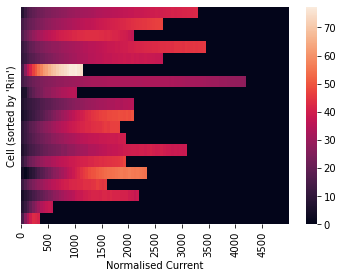

In [751]:
plot_heatmap(df_measurements, df_info, "Rin", norm=True)